In [1]:
''' notebook to work on the geometry encoding of the image
will have to create a basic geometry encoder based on the signed distance field 
So what is the idea? do we start from a signed distance field? or do we start from the segmentation and have 
a 2 stage process?
'''

'\xa0notebook to work on the geometry encoding of the image\nwill have to create a basic geometry encoder based on the signed distance field \nSo what is the idea? do we start from a signed distance field? or do we start from the segmentation and have \na 2 stage process?\n'

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import os, yaml, torch
from torch.nn import MSELoss, L1Loss
from torch.utils.data import DataLoader
curdir = os.getcwd()
os.chdir('..')
from data.data_generation import generate_dataset, generate_pipe_flow_dataset, generate_3dstenosis, generate_3daneurysm
os.chdir(curdir)

In [5]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

In [6]:
from train_geometry_submodule import PoseuilleFlowSDF

/notebooks/superresolution


In [7]:
model_name = '3daneurysm_3dstenosis_099_transforms_aug1_latent60_newmaps_sparsity50'
# loading the model config
with open(f"geometry_trainings/geometry_config_models/{model_name}.yml") as file:
    config = yaml.safe_load(file)

In [8]:
import importlib
specific_model = importlib.import_module(f'geometry_trainings.geometry_models.{model_name}')
ConvNet = specific_model.ConvNet

In [9]:
# setting device and data types
dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
print(device)

cuda


In [10]:
# volume size
nvox = config["nvox"]
epoch_sparsity = config["epoch_sparsity"]
target_sparsity = config["target_sparsity"]

# datasets
gen_stenosis = config["gen_stenosis"]
gen_aneurysm = config["gen_aneurysm"]
assert gen_stenosis or gen_aneurysm, 'You should at least generate stenosis flows or aneurysm flows.'

# augmentation
transforms = config["transforms"]
data_aug = config["data_aug"]

if gen_stenosis:
    _, _, _, sdfs, _ = generate_3dstenosis(
        nvox=64, 
        sdf=True,
        transforms=transforms,
        data_aug=data_aug,
        mode="eval"
    )

if gen_aneurysm:
    _, _, _, sdfs_aneurysm, _ = generate_3daneurysm(
        nvox=64, 
        sdf=True,
        transforms=transforms,
        data_aug=data_aug,
        mode="eval"
    )

if gen_stenosis and gen_aneurysm:
    # concatenate sdfs all together
    sdfs = np.concatenate((sdfs, sdfs_aneurysm), axis=0)
    del sdfs_aneurysm
# just pipe flows
elif gen_aneurysm:
    sdfs = sdfs_aneurysm

  0%|          | 0/20 [00:00<?, ?it/s]

Normalizing samples.
Creating segmentation maps.
Adding edges.
Created edges.
Add edges on the side.
Generating sfds.


100%|██████████| 20/20 [00:00<00:00, 32.25it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

Normalizing samples.
Creating segmentation maps.
Adding edges.
Created edges.
Add edges on the side.
Generating sfds.


100%|██████████| 20/20 [00:00<00:00, 31.42it/s]


In [11]:
# # flows, segmentation_maps, _, sdfs, velocity_scale_for_norm = generate_3dstenosis(nvox=nvox)
# # generate stenosis
# flows, segmentation_maps, _, sdfs, _ = generate_3daneurysm(
#     nvox=64, 
#     sdf=True, 
#     transforms=True, 
#     data_aug=1, 
#     mode="train"
# )

In [12]:
sdfs_min = np.min(sdfs, axis=(-1, -2, -3, -4, -5), keepdims=True)
sdfs_max = np.max(sdfs, axis=(-1, -2, -3, -4, -5), keepdims=True)

# normalize the sdfs
sdfs = (sdfs - sdfs_min)/(sdfs_max - sdfs_min)

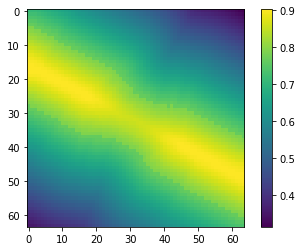

In [13]:
plt.imshow(sdfs[4, 0, :, :, 30])
plt.colorbar()

In [14]:
test_dataset = PoseuilleFlowSDF(sdfs)

In [15]:
# dataloaders
batch_size = config["batch_size"]
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# setup models
model = ConvNet(
    input_size=nvox, 
    channels_in=sdfs.shape[1], 
    channels_init=config["channels_init"],
    channels_out=config["channels_out"],
    latent_space_size=config["latent_space_size"],
)

In [17]:
checkpoint = torch.load(f"geometry_trainings/geometry_saved_models/{model_name}", map_location=torch.device("cpu"))
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device=device)
model.eval()
# set up losses
loss_function_mae = L1Loss()
loss_function_mse = MSELoss()

In [18]:
epoch_total_loss_mae = 0
epoch_total_loss_mse = 0
reconstructions = np.zeros_like(sdfs)
with torch.no_grad():
    counter = 0
    
    for i, sdf_batch in tqdm(enumerate(test_dataloader)):
        sdf_batch = sdf_batch.to(device=device, dtype=dtype) # move to device, e.g. GPU
        # =====================forward======================
        # compute latent vectors
        reconstruction = model(sdf_batch)
        loss_mae = loss_function_mae(reconstruction, sdf_batch)
        loss_mse = loss_function_mse(reconstruction, sdf_batch)
        
        reconstructions[counter:counter+len(sdf_batch), ...] = reconstruction.detach().cpu().numpy()
        counter += len(sdf_batch)
        
        # update write iteration loss
        epoch_total_loss_mae += (loss_mae.item()*len(sdf_batch))
        epoch_total_loss_mse += (loss_mse.item()*len(sdf_batch))
print(f"mae: {epoch_total_loss_mae/(len(test_dataset)):.2e}, mse: {epoch_total_loss_mse/(len(test_dataset)):.2e}")

0it [00:00, ?it/s]

mae: 8.35e-03, mse: 1.17e-04


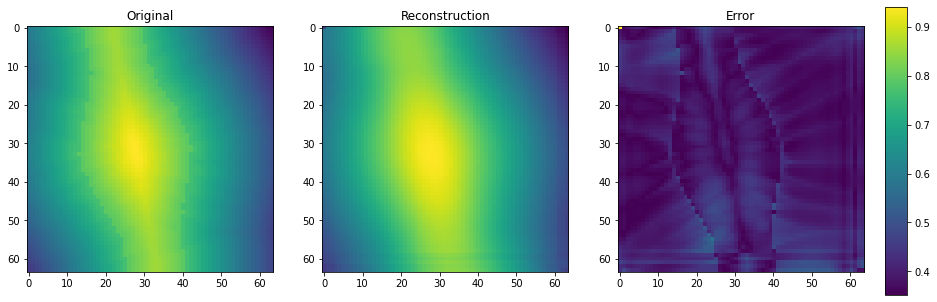

In [22]:
i = 28
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
im1 = ax[0].imshow(sdfs[i, 0, ..., 30])
ax[0].set_title('Original')
im2 = ax[1].imshow(reconstructions[i, 0, ..., 30])
ax[1].set_title('Reconstruction')
im3 = ax[2].imshow(np.abs(sdfs[i, 0, ..., 30] - reconstructions[i, 0, ..., 30]))
ax[2].set_title('Error')

# add a colorbar to the right of the plot
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4]) # [left, bottom, width, height]
cbar = plt.colorbar(im2, cax=cbar_ax)

plt.show()

Text(0.5, 1.0, 'Reconstruction')

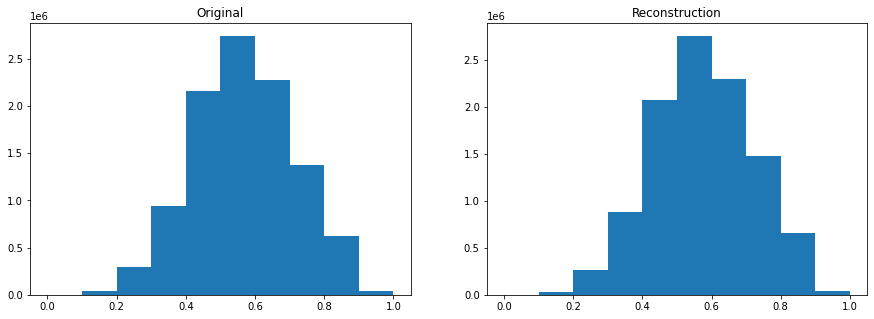

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
im1 = ax[0].hist(sdfs.flatten(), bins=10, range=(0,1))
ax[0].set_title('Original')
im2 = ax[1].hist(reconstructions.flatten(), bins=10, range=(0,1))
ax[1].set_title('Reconstruction')

In [48]:
# will look into different losses
# l1, l2, the one I read on with the angles
# cosine loss --> alignment of the vector at each point